In [ ]:
!pip install xgboost pyarrow

25/03/28 20:30:22 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


🎧 Listening to Kafka topics...
Company_A
📊 RMSE: 0.0860, MAE: 0.0860, R²: -inf


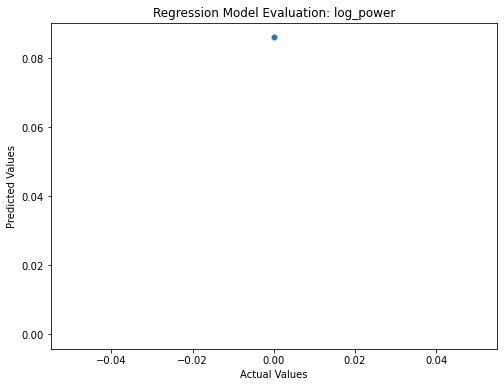

📊 Accuracy: 1.0000, F1-score: 1.0000


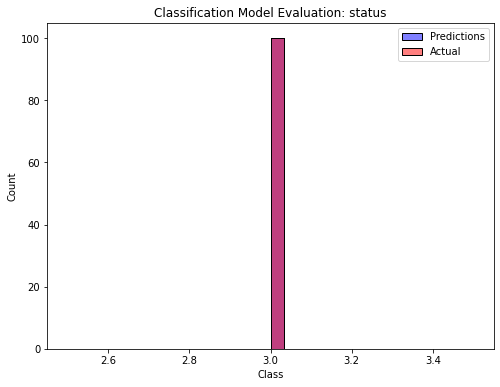

25/03/28 20:30:39 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/03/28 20:30:39 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


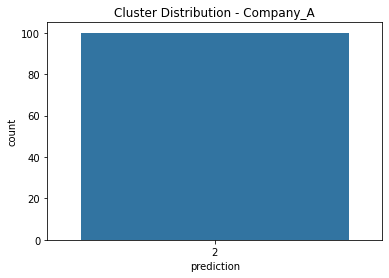

Company_A
📊 RMSE: 0.1086, MAE: 0.0938, R²: -1.4795


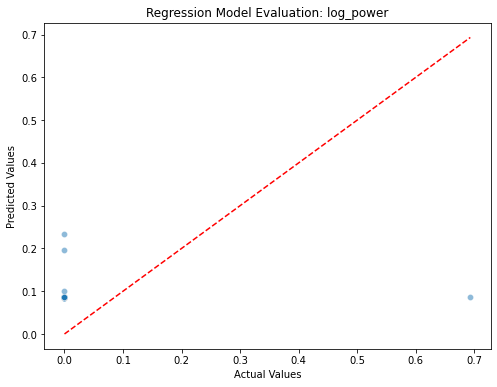

📊 Accuracy: 0.9900, F1-score: 0.9911


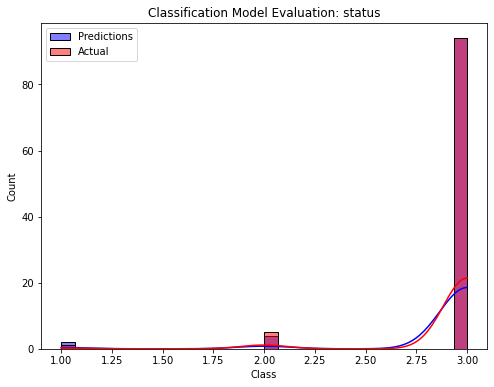

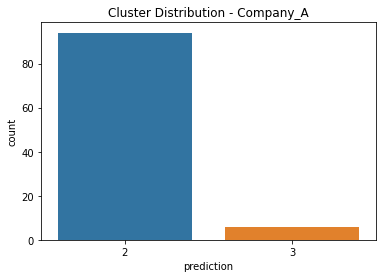

Company_A
📊 RMSE: 0.1216, MAE: 0.0990, R²: -0.5715


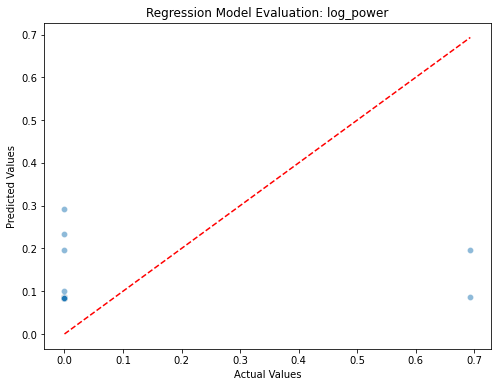

📊 Accuracy: 0.9800, F1-score: 0.9898


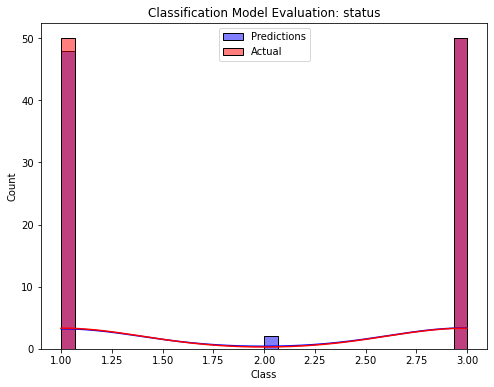

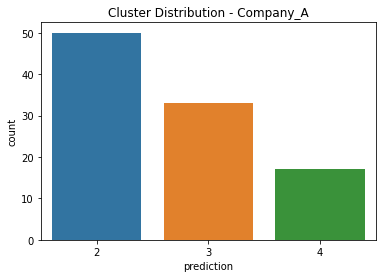

Company_A
📊 RMSE: 0.3214, MAE: 0.1881, R²: 0.5251


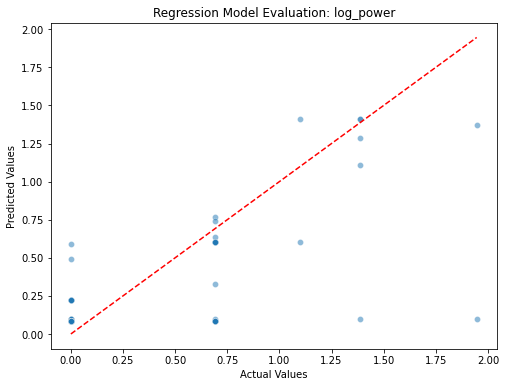

📊 Accuracy: 0.9400, F1-score: 0.9390


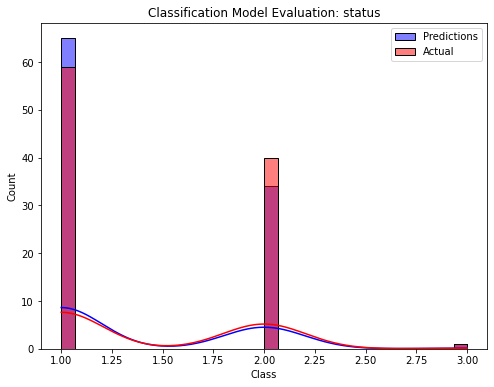

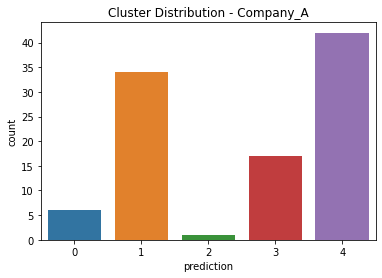

Company_A
📊 RMSE: 0.3893, MAE: 0.2504, R²: 0.7766


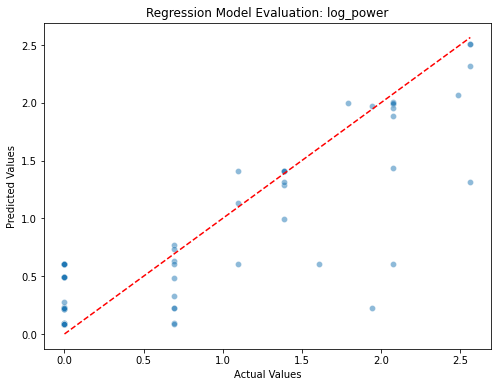

📊 Accuracy: 0.9200, F1-score: 0.9200


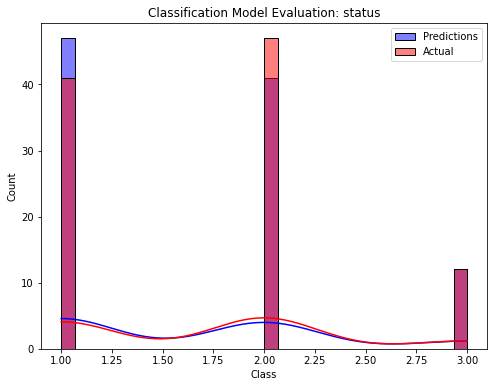

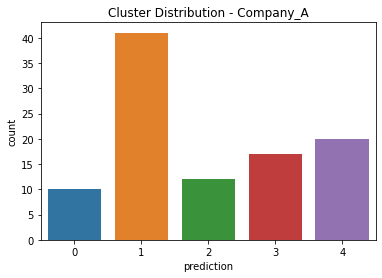

Company_A
📊 RMSE: 0.4171, MAE: 0.2021, R²: 0.6482


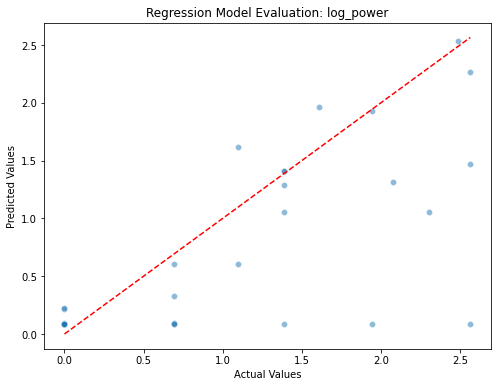

📊 Accuracy: 0.9400, F1-score: 0.9391


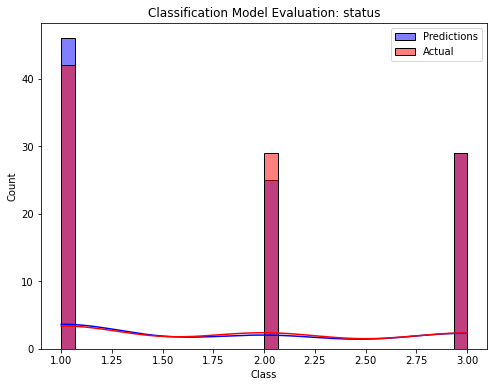

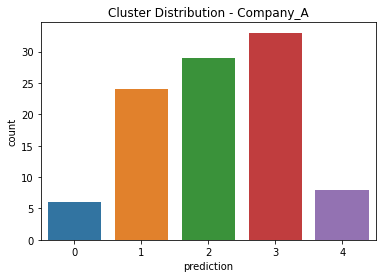

Company_A
📊 RMSE: 0.5080, MAE: 0.2482, R²: 0.4910


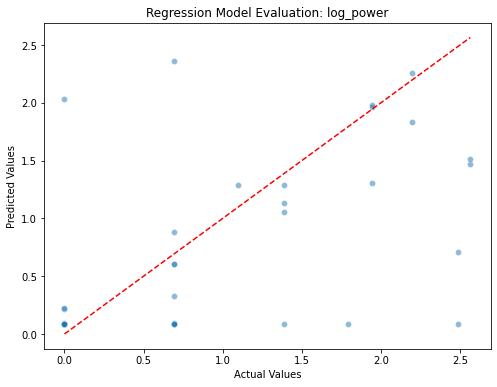

📊 Accuracy: 0.9200, F1-score: 0.9196


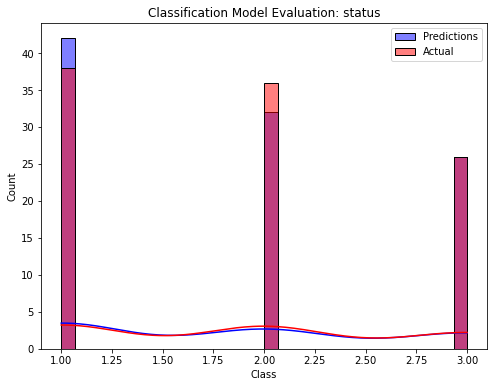

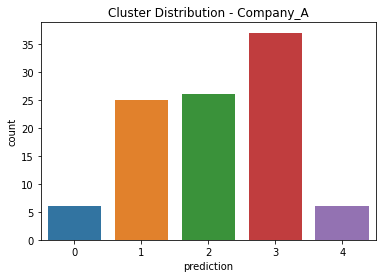

Company_A
📊 RMSE: 0.4129, MAE: 0.2535, R²: 0.7697


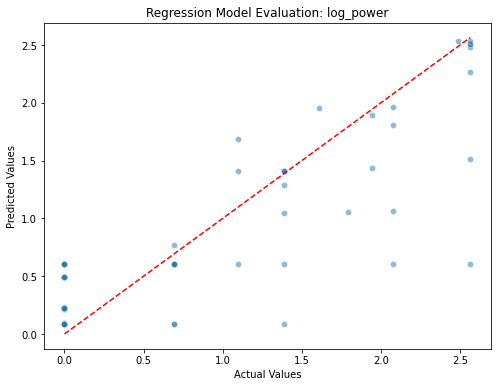

📊 Accuracy: 0.9200, F1-score: 0.9201


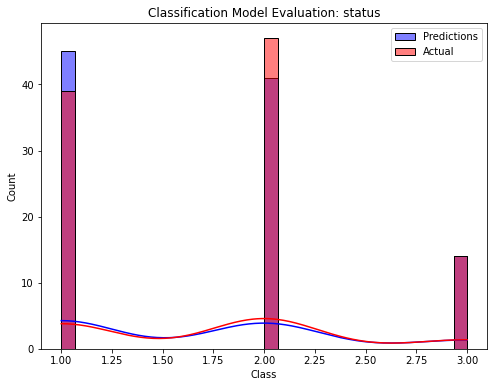

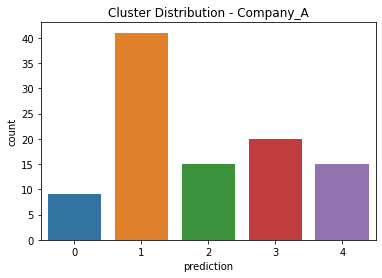

Company_A
📊 RMSE: 0.4226, MAE: 0.2602, R²: 0.7935


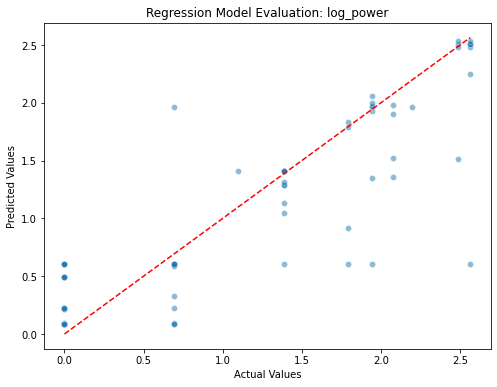

📊 Accuracy: 0.9200, F1-score: 0.9211


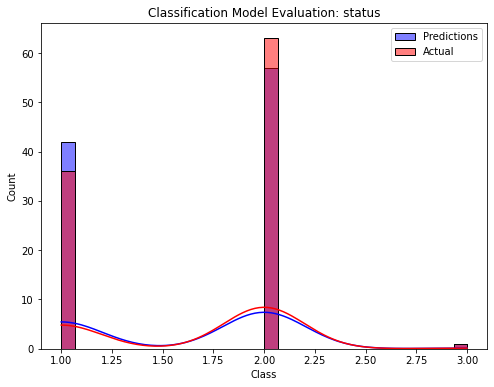

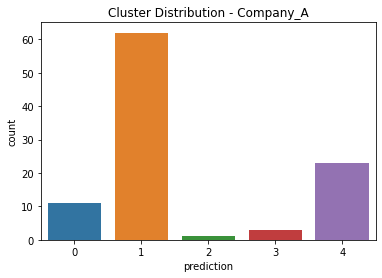

Company_A
📊 RMSE: 0.4321, MAE: 0.2007, R²: 0.4968


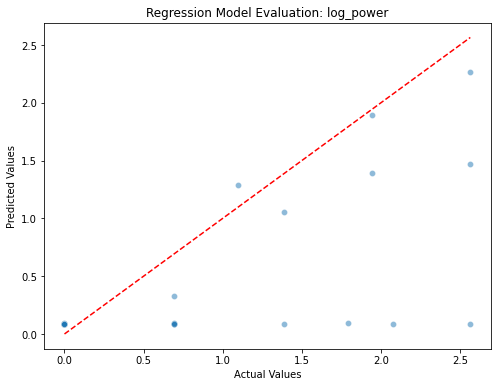

📊 Accuracy: 0.9500, F1-score: 0.9436


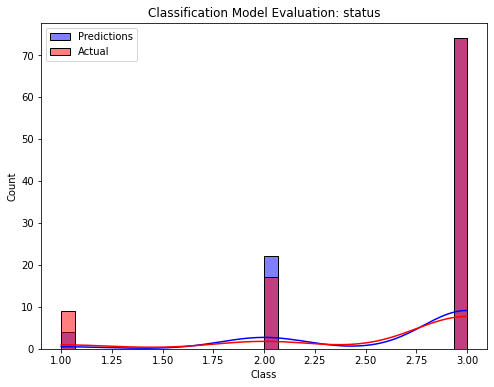

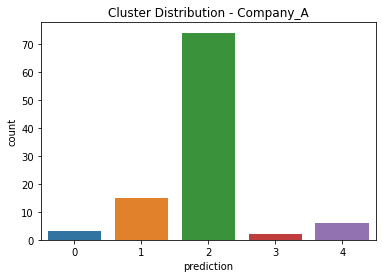

Company_A
📊 RMSE: 0.0859, MAE: 0.0859, R²: -inf


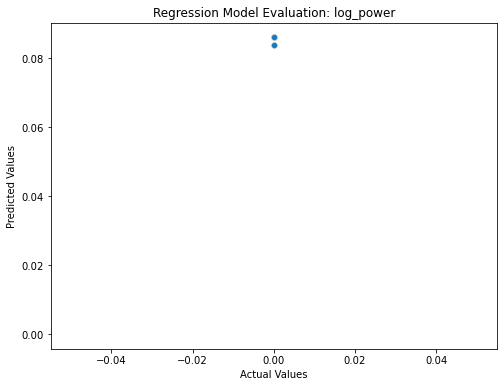

📊 Accuracy: 0.9900, F1-score: 0.9911


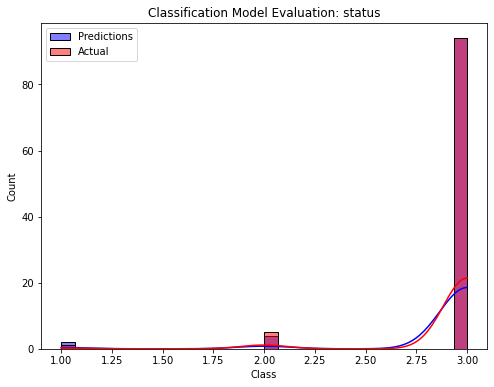

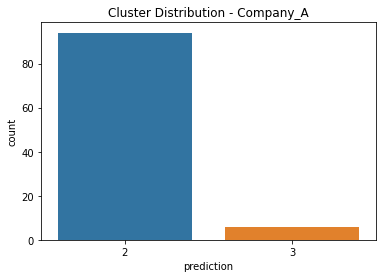

Company_A
📊 RMSE: 0.1390, MAE: 0.1075, R²: -0.3819


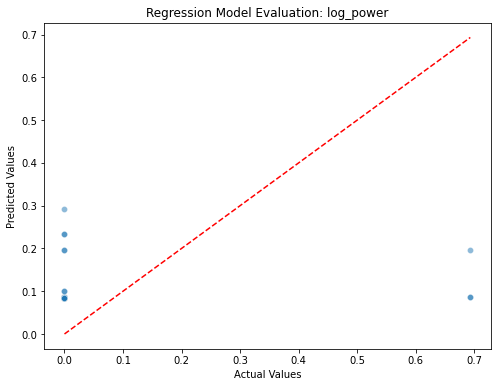

📊 Accuracy: 0.9800, F1-score: 0.9896


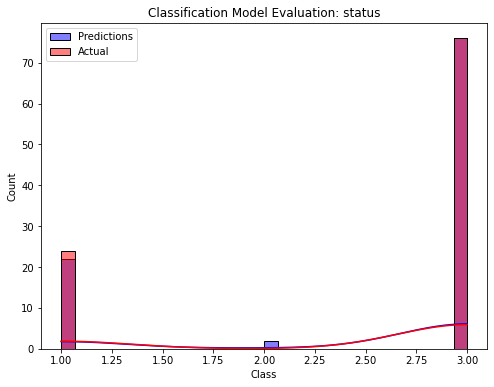

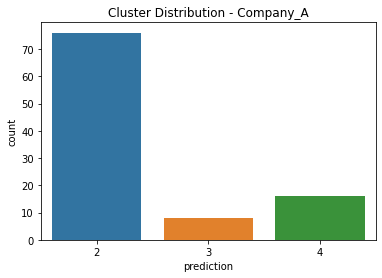

Company_A
📊 RMSE: 0.2273, MAE: 0.1428, R²: 0.4639


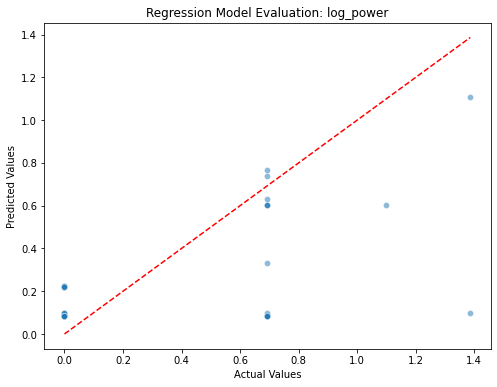

📊 Accuracy: 0.9600, F1-score: 0.9589


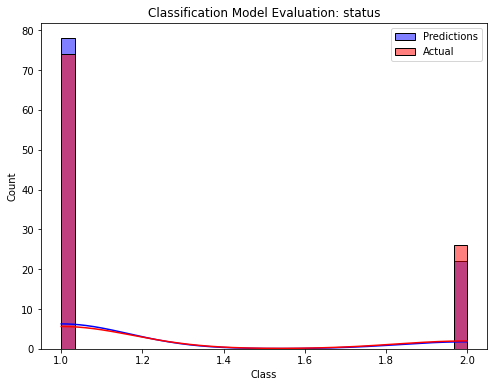

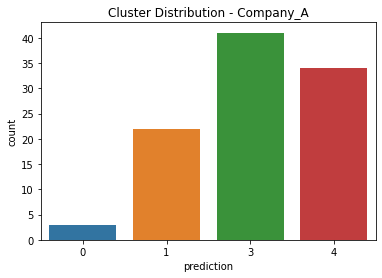

Company_B
📊 RMSE: 0.8426, MAE: 0.5667, R²: 0.6598
25/03/28 20:31:53 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


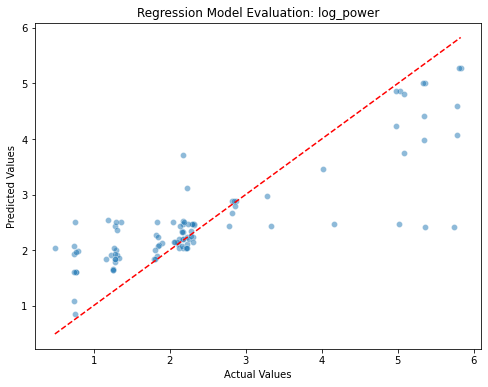

📊 Accuracy: 0.7200, F1-score: 0.7009


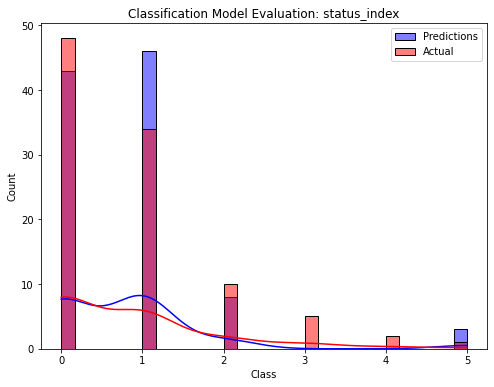

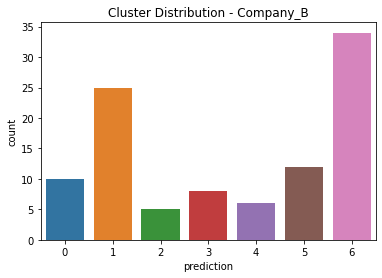

Company_B
📊 RMSE: 0.8050, MAE: 0.5431, R²: 0.6337


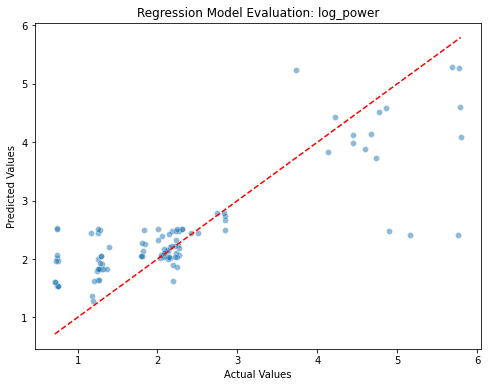

📊 Accuracy: 0.7500, F1-score: 0.7433


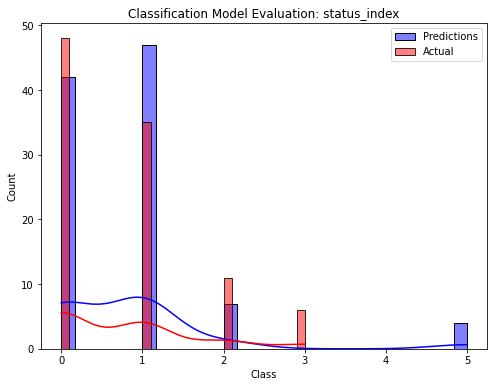

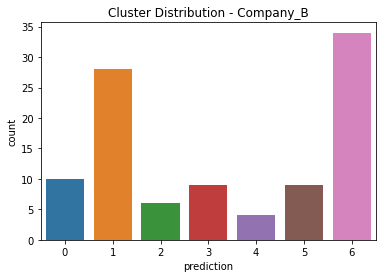

Company_B
📊 RMSE: 0.8212, MAE: 0.5871, R²: 0.5423


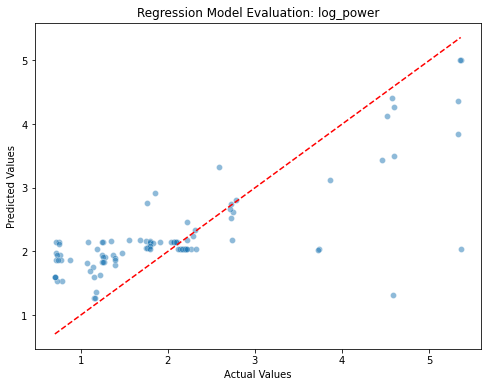

📊 Accuracy: 0.7000, F1-score: 0.6999


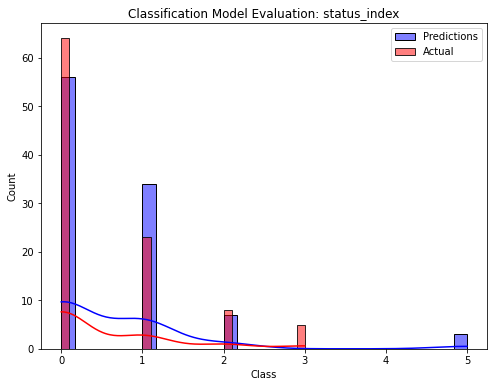

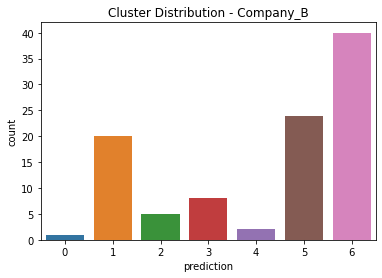

Company_B


ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/spark/python/lib/py4j-0.10.9.5-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/spark/spark/python/lib/py4j-0.10.9.5-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/home/linuxu/anaconda3/lib/python3.9/socket.py", line 704, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt
ERROR:kafka.consumer.fetcher:Fetch to node 0 failed: Cancelled: <BrokerConnection node_id=0 host=ParallelC23b-10.academic.management.afeka.local:9092 <connected> [IPv4 ('127.0.1.1', 9092)]>


❌ Kafka Consumer Stopped by User.
👋 Kafka connection closed.


In [ ]:
import logging
import json
import pandas as pd
from kafka import KafkaConsumer
from datetime import datetime

from pyspark.sql import SparkSession, Row
from pyspark.sql.types import (
    TimestampType, StructType, StructField, StringType,
    IntegerType, FloatType
)
from pyspark.ml.feature import StringIndexer

import matplotlib.pyplot as plt
import seaborn as sns

from spark_model_utility import DataProcessor, ModelEvaluator

# Kafka Configuration
KAFKA_BROKER = "localhost:9092"
TOPICS = ["Company_A", "Company_B"]

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("KafkaConsumer_CompanyB") \
    .getOrCreate()

# Configure logger
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("KafkaSparkPredictor")

# Initialize utility classes
processor = DataProcessor(spark)
evaluator = ModelEvaluator(spark)

evaluator.load_model("power_forecast_B")
evaluator.load_model("next_state_forecast_B")

#Write schemas for each Dataset

schema_A = StructType([
    StructField("ts", TimestampType(), True),
    StructField("asset", IntegerType(), True),
    StructField("items", FloatType(), True),
    StructField("status", IntegerType(), True),
    StructField("status_time", FloatType(), True),
    StructField("power_avg", FloatType(), True),
    StructField("cycle_time", FloatType(), True),
    StructField("alarm", IntegerType(), True)
])

schema_B = StructType([
    StructField("ts", TimestampType(), True),
    StructField("asset", IntegerType(), True),
    StructField("status", StringType(), True),
    StructField("alarm_time", FloatType(), True),
    StructField("loading_time", FloatType(), True),
    StructField("tooling_time", FloatType(), True),
    StructField("maintenance_time", FloatType(), True),
    StructField("support_time", FloatType(), True),
    StructField("power_avg", FloatType(), True),
    StructField("power_min", FloatType(), True),
    StructField("power_max", FloatType(), True)
])


# Kafka consumer setup
consumer = KafkaConsumer(
    bootstrap_servers=KAFKA_BROKER,
    value_deserializer=lambda v: json.loads(v.decode("utf-8")),
    auto_offset_reset="earliest",
    enable_auto_commit=True
)

consumer.subscribe(TOPICS)

# In-memory buffer
data_buffer = []
batch_size = 100

# Initialize empty cumulative DataFrame
all_data_sdf = spark.createDataFrame([], schema_B)

def convert_to_row(record):
    record = record.copy()
    if isinstance(record.get("ts"), str):
        record["ts"] = pd.to_datetime(record["ts"]).to_pydatetime()
    return Row(**record)

def process_spark_batch(batch, schema, topic):
    global all_data_sdf

    print(topic)

    rows = [convert_to_row(rec) for rec in batch]
    sdf = spark.createDataFrame(rows, schema=schema)
    if topic == "Company_B":
    # Convert categorical 'status' in df_B to numerical labels
        indexer = StringIndexer(inputCol="status", outputCol="status_index")
        sdf = indexer.fit(sdf).transform(sdf).drop("status")

    # Preprocessing
    sdf = processor.extract_time_features(sdf, timestamp_col="ts")
    sdf = processor.log_transform_column(sdf, input_col="power_avg", output_col="log_power")
    if topic == "Company_A":
        sdf = processor.add_lag_features(sdf, asset_col="asset", time_col="ts_unix", target_cols=["log_power", "status"])
    elif topic == "Company_B":
        sdf = processor.add_lag_features(sdf, asset_col="asset", time_col="ts_unix", target_cols=["log_power", "status_index"])

    # Predictions
    power_preds = evaluator.load_model("power_forecast_A").transform(sdf) if topic == "Company_A" else evaluator.load_model("power_forecast_B").transform(sdf)
    state_preds = evaluator.load_model("next_state_forecast_A").transform(sdf) if topic == "Company_A" else evaluator.load_model("next_state_forecast_B").transform(sdf)
    item_class = evaluator.load_model("item_classification_A").transform(sdf) if topic == "Company_A" else evaluator.load_model("item_classification_B").transform(sdf)

    # Evaluation
    evaluator.evaluate_regression(power_preds,"log_power")
    evaluator.evaluate_classification(state_preds, "status_index" if topic == "Company_B" else "status")

    if topic == "Company_A"
      product_count = evaluator.load_model("production_count_forecast_A").transform(sdf)
      evaluator.evaluate_regression(product_count,"items")

    sns.countplot(data=item_class.toPandas(), x="prediction")
    plt.title(f"Cluster Distribution - {topic}")
    plt.show()

    # Save batch to disk and accumulate
    sdf.write.mode("append").parquet(f"{topic}_data.parquet")
    all_data_sdf = all_data_sdf.unionByName(sdf, allowMissingColumns=True)

    logger.info(f"✅ Processed and saved batch of {len(batch)} records.")

# Topic-specific buffers
topic_buffers = {"Company_A": [], "Company_B": []}

print(f"🎧 Listening to Kafka topics...")

try:
    for message in consumer:
        topic = message.topic
        data = message.value
        topic_buffers[topic].append(data)

        if len(topic_buffers[topic]) >= batch_size:
            schema = schema_B if topic == "Company_B" else schema_A
            process_spark_batch(topic_buffers[topic], schema, topic)
            topic_buffers[topic].clear()

except KeyboardInterrupt:
    print("❌ Kafka Consumer Stopped by User.")
finally:
    consumer.close()
    print("👋 Kafka connection closed.")



In [ ]:
# Read all parquet files in the folder
df_A = spark.read.parquet("Company_A_data.parquet")  # or your full folder path
# Save as CSV
df_A.write.mode("overwrite").option("header", True).csv("Company_A_data_csv")

df_B = spark.read.parquet("Company_B_data.parquet")  # or your full folder path
df_B.write.mode("overwrite").option("header", True).csv("Company_B_data_csv")